<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="33%"/>
  </p>
  
# **Trabajo Práctico 1: Reservas de Hotel**
### **Checkpoint**: 2
### **Grupo**: 11 - Los Pandas
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo Suster
### **Integrantes**:
### 103456 - Labollita, Francisco
### 102312 - Mundani Vegega, Ezequiel
###  97263 - Otegui, Matías Iñaki

# Clasificación - Entrenamiento y Predicción

### Carga inicial de dependencias y datos

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
import dtreeviz
import warnings

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

# Aclaración:
# Hay un warning que puede llegar a aparecer que es debido a una actualización interna de Seaborn que será deprecada, para solucionarlo hay que modificar el código de python
# directamente (lo cual no es una buena práctica).
# La función en concreto se va a seguir utilizando, por lo que no afecta a nuestro código en sí, si no al comportamiento interno de dicha función.
# Se propone ignorar dicho warninig, ya que se solucionará en la próxima versión de Python
# En el siguiente enlace se puede encontrar más información:
# https://github.com/ultralytics/ultralytics/issues/4729
# https://github.com/mwaskom/seaborn/issues/3462
#
# se puede ignorar descomentando las siguientes líneas

warnings.filterwarnings('ignore', 'is_categorical_dtype is deprecated')
warnings.filterwarnings("ignore", "use_inf_as_na")

# o bien otra solución (más elegante), es obtener dicha actualización corriendo esta línea:
# pip install -U ultralytics

In [2]:
hotels_df = pd.read_csv('hotels_train.csv')
hotels_df_backup = hotels_df.copy()
hotels_df_mod = hotels_df.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)

hotels_df_mod = hotels_df_mod.dropna(subset=['country', 'distribution_channel', 'market_segment'])

hotels_df_mod['required_car_parking_spaces'] = hotels_df_mod['required_car_parking_spaces'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['required_car_parking_spaces'] = hotels_df_mod['required_car_parking_spaces'].astype(bool)

hotels_df_mod['days_in_waiting_list'] = hotels_df_mod['days_in_waiting_list'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['days_in_waiting_list'] = hotels_df_mod['days_in_waiting_list'].astype(bool)

hotels_df_mod['babies'] = hotels_df_mod['babies'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['babies'] = hotels_df_mod['babies'].astype(bool)

hotels_df_mod['previous_cancellations'] = hotels_df_mod['previous_cancellations'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['previous_cancellations'] = hotels_df_mod['previous_cancellations'].astype(bool)

hotels_df_mod['total_of_special_requests'] = hotels_df_mod['total_of_special_requests'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['total_of_special_requests'] = hotels_df_mod['total_of_special_requests'].astype(bool)

hotels_df_mod['previous_bookings_not_canceled'] = hotels_df_mod['previous_bookings_not_canceled'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['previous_bookings_not_canceled'] = hotels_df_mod['previous_bookings_not_canceled'].astype(bool)

hotels_df_mod['booking_changes'] = hotels_df_mod['booking_changes'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['booking_changes'] = hotels_df_mod['booking_changes'].astype(bool)
hotels_df_mod = hotels_df_mod.drop(hotels_df_mod[hotels_df_mod['adults'] > 4].index)

hotels_df_mod['agent'] = hotels_df_mod['agent'].astype(str)
hotels_df_mod['agent'] = hotels_df_mod['agent'].replace('nan', 'Undefined')

# renombrar columna del dataframe de reserved_room_type a room_type_match
hotels_df_mod = hotels_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

hotels_df_mod.loc[hotels_df_mod['room_type_match'] == hotels_df_mod['assigned_room_type'], 'room_type_match'] = True
hotels_df_mod.loc[hotels_df_mod['room_type_match'] != hotels_df_mod['assigned_room_type'], 'room_type_match'] = False

hotels_df_mod['room_type_match'] = hotels_df_mod['room_type_match'].astype(bool)

In [3]:
hotels_df_mod.to_csv('hotels_df_modified.csv', index=False)

In [4]:
hotels_df = pd.read_csv('hotels_df_modified.csv')
hotels_df_backup = hotels_df.copy()

In [5]:
#One hot encoding para variables categoricas
hotels_df_x = pd.get_dummies(hotels_df, columns=["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type", "deposit_type", "customer_type", "agent" ], drop_first=True)

#Creo un dataset con los features que voy a usar para clasificar
hotels_df_x = hotels_df_x.drop(['is_canceled'], axis='columns')

hotels_df_x = hotels_df_x.reindex(sorted(hotels_df_x.columns), axis=1)

#Creo un dataset con la variable target
hotels_df_y = hotels_df['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(hotels_df_x,
                                                    hotels_df_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

tree_model = tree.DecisionTreeClassifier()

## Se varían los hiperparámetros

Para elegir los mejores hiperparámetros se decidió iterar de manera parecida a una búsqueda binaria. Se decidió variarlos utilizando una búsqueda en grilla, dado a que realizando un barrido lineal y luego realizar uno nuevo sobre el mejor intervalo encontrado se cree que se tendrán mejores valores que buscando al azar. También se creé que de esta manera se tardará menos al mismo tiempo que se analizarán solo los puntos más importantes.

Primero se buscó el mejor *max_depth*, luego el mejor criterio, luego los *min_samples_split* y *min_samples_leaf* y por último se realizó una búsqueda logarítmica para el mejor alpha.

Se obtuvo que los mejores hiperparámetros (utilizando el F1 score como métrica) para este caso son:

- *ccp_alpha* = $10^{-4,42}$
- Criterio = Gini
- *max_depth* = 16
- *min_samples_split* = 2
- *min_samples_leaf* = 2
- *folds* = 16

Siendo el F1 score = 0,8452

In [6]:
params_grid = {'max_depth':list(range(1,25,5)),
               'random_state': [2]}

folds=10

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )

model = gridcv.fit(x_train,y_train)

print(gridcv.best_params_)
print(gridcv.best_score_)

{'max_depth': 16, 'random_state': 2}
0.8419502590507367


In [7]:
params_grid = {'max_depth':list(range(12,20,2)),
               'random_state': [2]}

folds=10

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )

model = gridcv.fit(x_train,y_train)

print(gridcv.best_params_)
print(gridcv.best_score_)

{'max_depth': 16, 'random_state': 2}
0.8419502590507367


In [8]:
params_grid = {'criterion':['gini','entropy','log_loss'],
               'max_depth':list(range(15,18,1)),
               'random_state': [2]}

folds=10

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )


model = gridcv.fit(x_train,y_train)

print(gridcv.best_params_)
print(gridcv.best_score_)

{'criterion': 'gini', 'max_depth': 16, 'random_state': 2}
0.8419502590507367


In [9]:
params_grid = {'criterion':['gini'],
               'min_samples_leaf':list(range(2,500,100)),
               'min_samples_split': list(range(2,500, 100)),
               'max_depth':[16],
               'random_state': [2]}

folds=10

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )

model = gridcv.fit(x_train,y_train)

print(gridcv.best_params_)
print(gridcv.best_score_)

{'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 2}
0.8409346621256478


In [10]:
params_grid = {'criterion':['gini'],
               'min_samples_leaf':list(range(2,100,20)),
               'min_samples_split': list(range(2,100, 20)),
               'max_depth':[16],
               'random_state': [2]}

folds=10

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )


model = gridcv.fit(x_train,y_train)

print(gridcv.best_params_)
print(gridcv.best_score_)

{'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 2}
0.8409346621256478


In [11]:
params_grid = {'criterion':['gini'],
               'min_samples_leaf':list(range(2,10,4)),
               'min_samples_split': list(range(2,10, 4)),
               'max_depth':[16],
               'random_state': [2]}

folds=10

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )


model = gridcv.fit(x_train,y_train)

print(gridcv.best_params_)
print(gridcv.best_score_)

{'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 2}
0.8409346621256478


In [12]:
params_grid = {'criterion':['gini'],
               'min_samples_leaf':list(range(2,6,1)),
               'min_samples_split': list(range(2,6,1)),
               'max_depth':[16],
               'random_state': [2]}

folds=10

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )

model = gridcv.fit(x_train,y_train)

print(gridcv.best_params_)
print(gridcv.best_score_)

{'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 5, 'random_state': 2}
0.8409679601949955


In [13]:
params_grid = {'criterion':['gini', 'entropy', 'log_loss'],
               'max_depth':[16],
               'random_state': [2]}

folds=10

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )


model = gridcv.fit(x_train,y_train)

print(gridcv.best_params_)
print(gridcv.best_score_)

{'criterion': 'gini', 'max_depth': 16, 'random_state': 2}
0.8419502590507367


In [14]:
params_grid = {'criterion':['gini'],
               'ccp_alpha': np.logspace(-4, -6, 5),
               'max_depth':[16],
               'random_state': [2]}

folds=10

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )


model = gridcv.fit(x_train,y_train)

print(gridcv.best_params_)
print(gridcv.best_score_)

{'ccp_alpha': 3.1622776601683795e-05, 'criterion': 'gini', 'max_depth': 16, 'random_state': 2}
0.8427054796207004


In [15]:
params_grid = {'criterion':['gini'],
               'ccp_alpha': np.logspace(-4, -5, 5),
               'max_depth':[16],
               'random_state': [2]}

folds=10

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )


model = gridcv.fit(x_train,y_train)

print(gridcv.best_params_)
print(gridcv.best_score_)

{'ccp_alpha': 3.1622776601683795e-05, 'criterion': 'gini', 'max_depth': 16, 'random_state': 2}
0.8427054796207004


In [16]:
params_grid = {'criterion':['gini'],
               'ccp_alpha': np.logspace(-4.4, -4.6, 10),
               'max_depth':[16],
               'random_state': [2]}

folds=10

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )


model = gridcv.fit(x_train,y_train)

print(gridcv.best_params_)
print(gridcv.best_score_)

{'ccp_alpha': 3.7824899063893825e-05, 'criterion': 'gini', 'max_depth': 16, 'random_state': 2}
0.8428866197113228


In [17]:
params_grid = {'criterion':['gini'],
               'ccp_alpha': [10**(-4.42)],
               'max_depth':[16],
               'random_state': [2]}

for folds in range (2, 20, 2):
    kfoldcv = StratifiedKFold(n_splits=folds)

    scorer_fn = make_scorer(f1_score)

    gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )


    model = gridcv.fit(x_train,y_train)

    print("Folds:",folds, " F1 Score:", gridcv.best_score_)

Folds: 2  F1 Score: 0.8312443449050824
Folds: 4  F1 Score: 0.83772123474802
Folds: 6  F1 Score: 0.8428072871956561
Folds: 8  F1 Score: 0.8428684771929129
Folds: 10  F1 Score: 0.8428083545361955
Folds: 12  F1 Score: 0.8428644606986041
Folds: 14  F1 Score: 0.8427714244259227
Folds: 16  F1 Score: 0.8451931662784122
Folds: 18  F1 Score: 0.8419633038362314


In [18]:
params_grid = {'criterion':['gini'],
               'ccp_alpha': [10**(-4.42)],
               'max_depth':[16],
               'random_state': [2]}

for folds in range (15, 18, 1):
    kfoldcv = StratifiedKFold(n_splits=folds)

    scorer_fn = make_scorer(f1_score)

    gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )


    model = gridcv.fit(x_train,y_train)

    print("Folds:",folds, " F1 Score:", gridcv.best_score_)

Folds: 15  F1 Score: 0.8440530818723228
Folds: 16  F1 Score: 0.8451931662784122
Folds: 17  F1 Score: 0.8420276395184847


## Predicción sobre el conjunto test_data de hotels_train con el mejor modelo obtenido

In [19]:
params_grid = {'criterion':['gini'],
               'ccp_alpha': [10**(-4.42)],
               'max_depth':[16],
               'random_state': [2]}

folds=16
kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=tree_model,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )

model = gridcv.fit(x_train,y_train)

In [20]:
model.best_estimator_.get_params()

{'ccp_alpha': 3.8018939632056124e-05,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 16,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 2,
 'splitter': 'best'}

In [21]:
#Realizamos una predicción sobre el set de test
y_pred = model.predict(x_test)
#Valores Predichos
y_pred

#Valores Reales
y_test.values

#Probemos verlos juntos en un DataFrame
ds_resultados=pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
ds_resultados.head(10)

,test,pred
0,1,0
1,0,0
2,1,1
3,1,1
4,0,0
5,1,1
6,1,1
7,0,0
8,1,1
9,1,1


Text(50.722222222222214, 0.5, 'True')

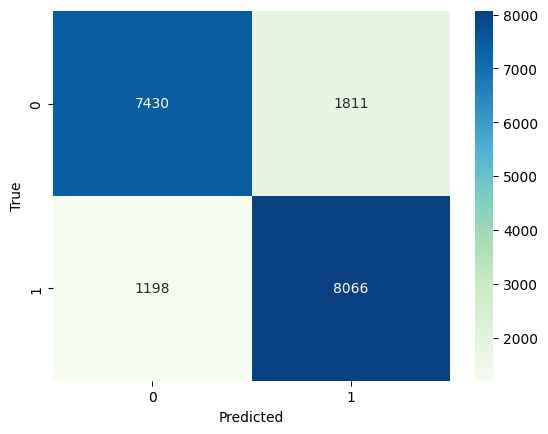

In [22]:
tabla=confusion_matrix(y_test, y_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [23]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

print(classification_report(y_test,y_pred))

Accuracy: 0.8373952985679546
Recall: 0.8706822107081175
Precision: 0.8166447301812291
f1 score: 0.8427981819131707
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      9241
           1       0.82      0.87      0.84      9264

    accuracy                           0.84     18505
   macro avg       0.84      0.84      0.84     18505
weighted avg       0.84      0.84      0.84     18505



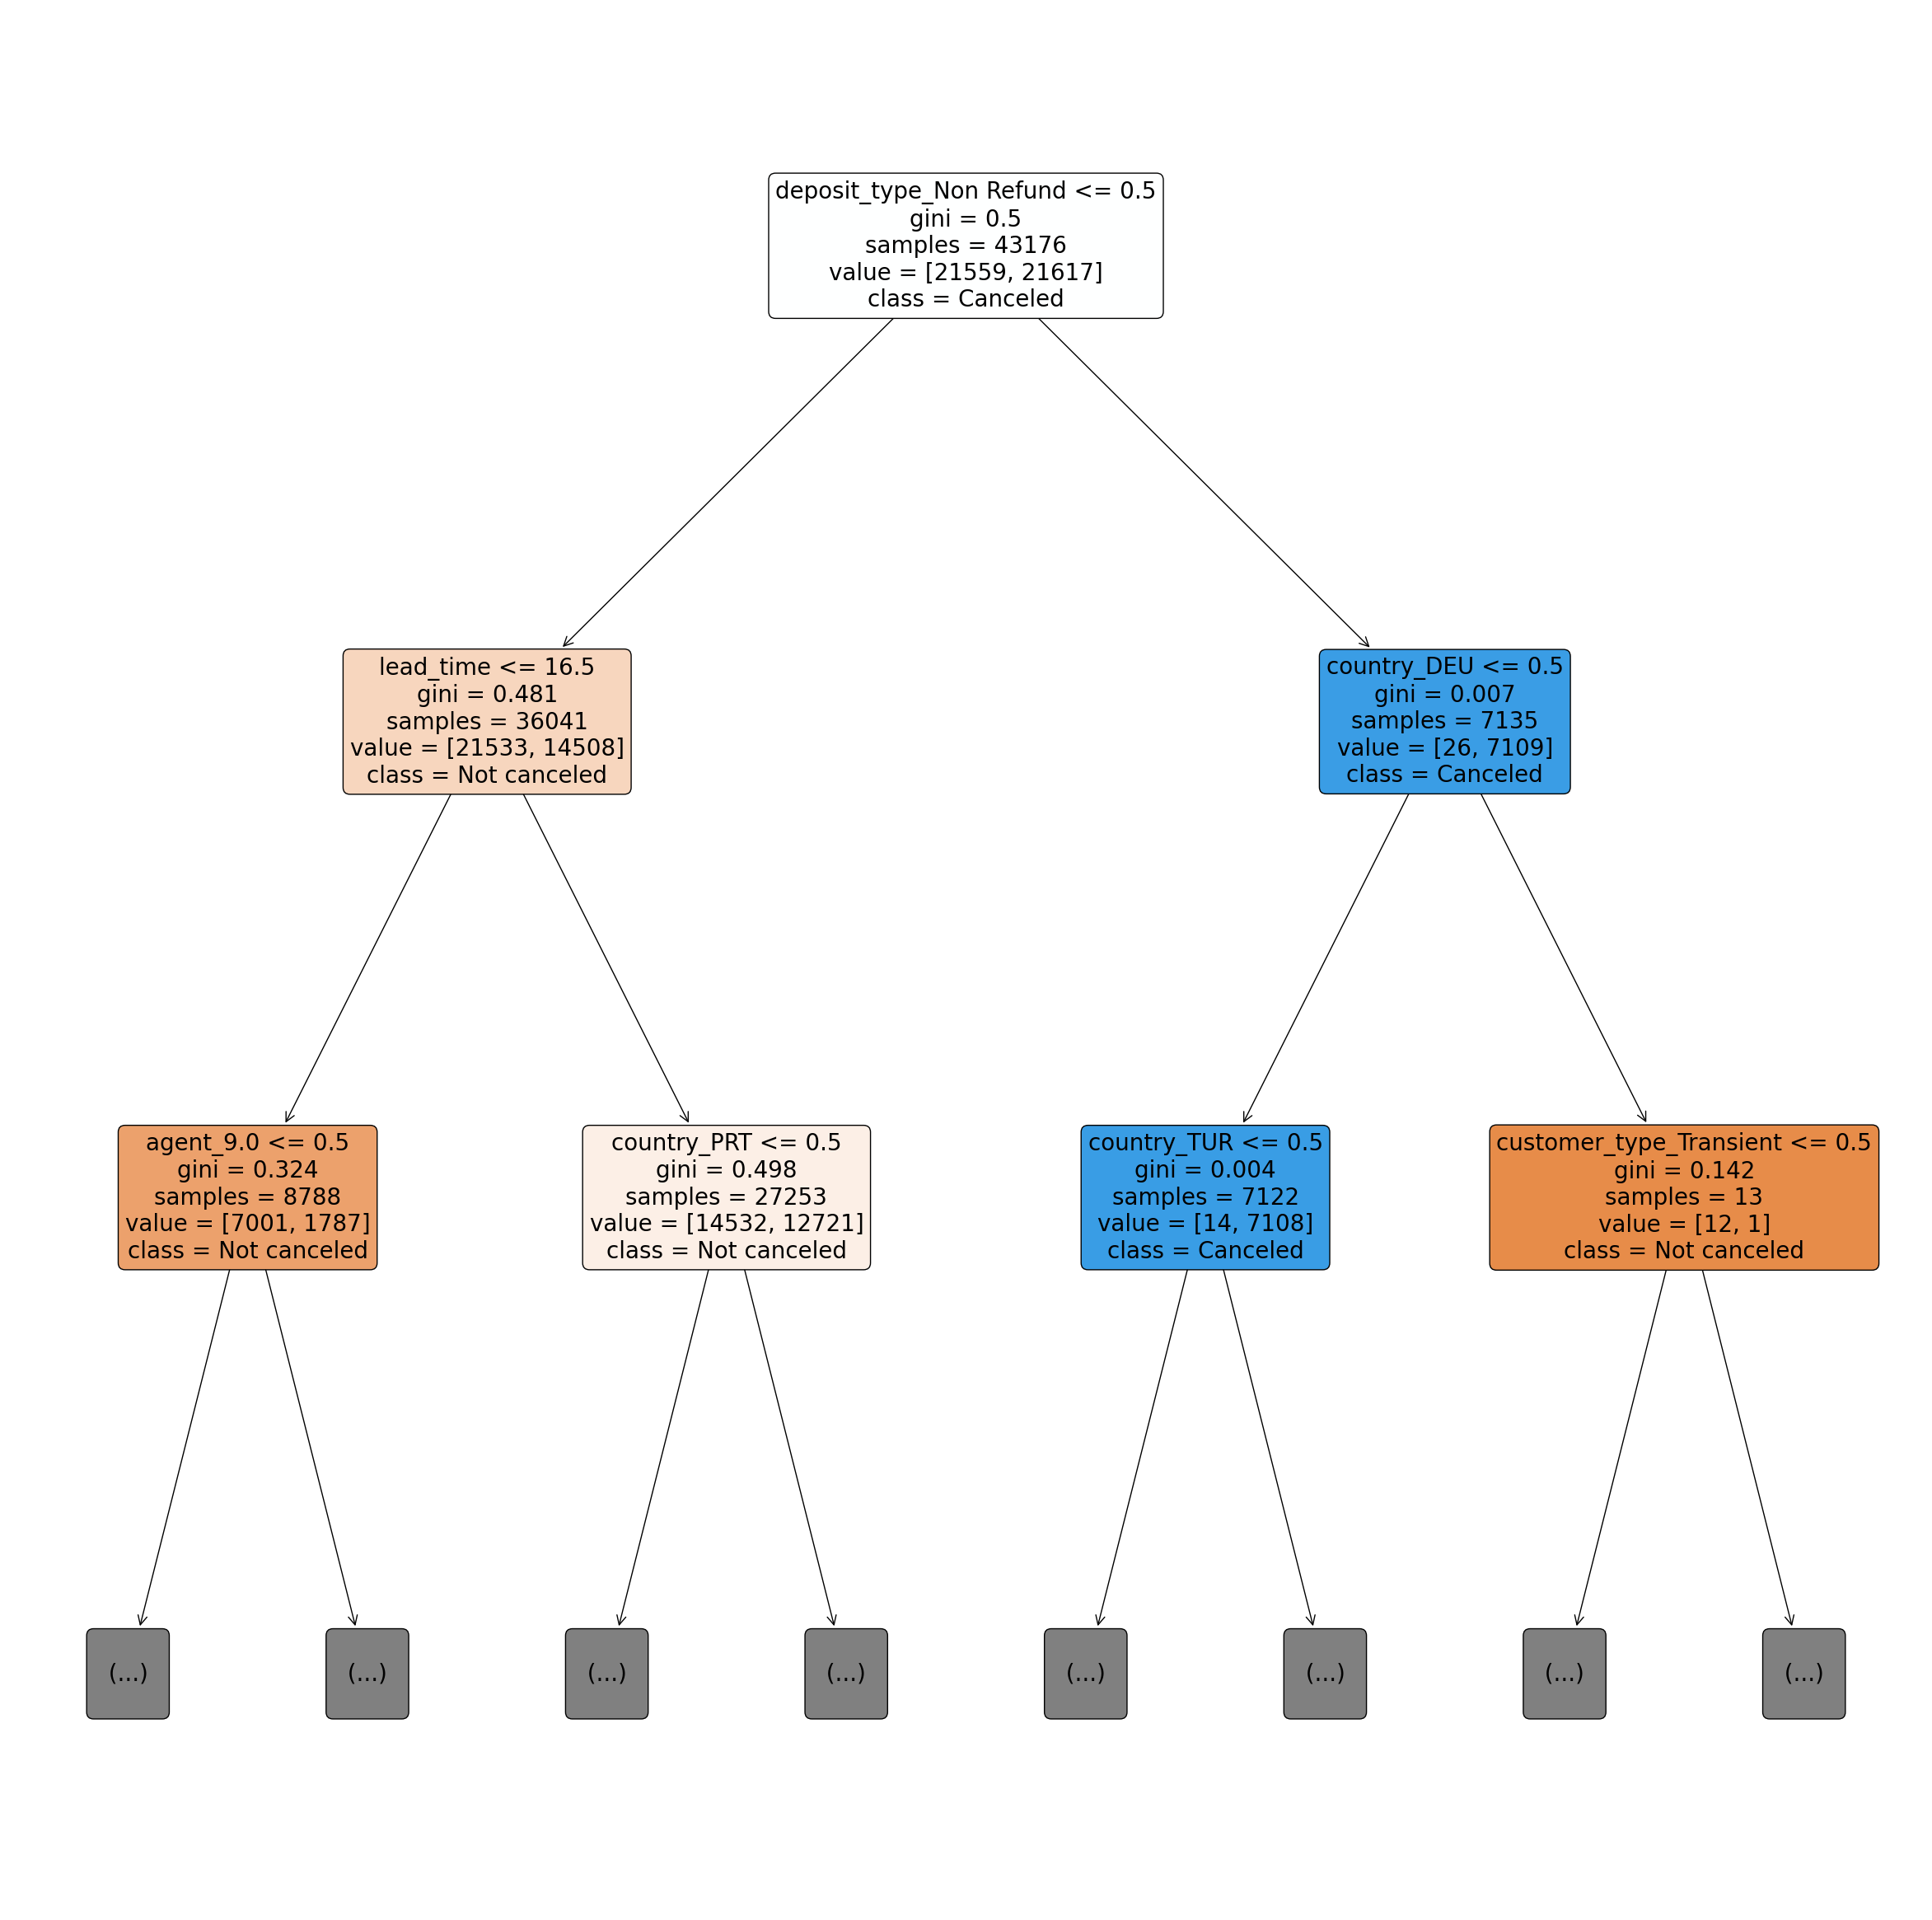

In [24]:
plt.figure(figsize=(30,30))

tree_plot_completo=tree.plot_tree(model.best_estimator_,
                                 feature_names=hotels_df_x.columns.to_list(),
                                 filled=True,
                                 rounded=True,
                                 class_names=['Not canceled','Canceled'],
                                 max_depth = 2,
                                 fontsize=20)
plt.show(tree_plot_completo)

c:\Users\ezequ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


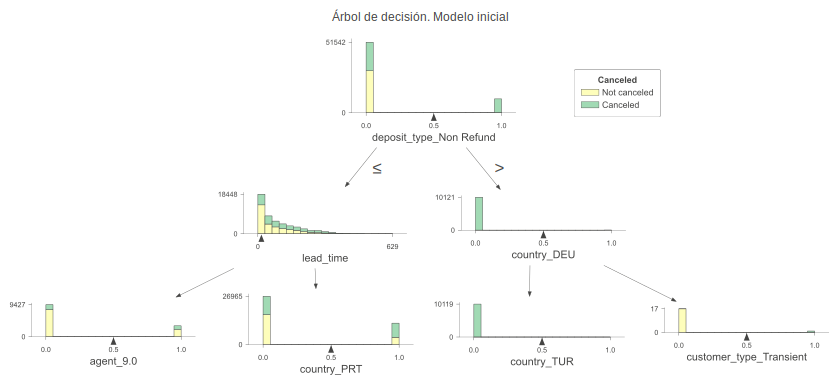

In [25]:
viz_model = dtreeviz.model(model.best_estimator_,
                            X_train=hotels_df_x, y_train=hotels_df_y,
                            feature_names=hotels_df_x.columns.to_list(),
                            target_name='Canceled',
                            class_names=['Not canceled','Canceled'])

v = viz_model.view(scale = 1.2, title = 'Árbol de decisión. Modelo inicial', depth_range_to_display=(0,2))
display(v)

Analizando ambos gráficos de árbol y la siguiente tabla, se ve que el nodo más importante es deposit_type_Non Refund, que es uno de los dummies generados para la variable deposit_type. Esto se vio en el checkpoint 1 dado a que la gran mayoría que tenía este tipo de depósito tendía a cancelar.

Analizando los gráficos de los mejores árboles de decisión obtenidos, se ve que primero se analiza si el depósito es de tipo *Non refund*. En caso de serlo, se fija si la persona viene del país con código DEU. Si lo es se fija si el tipo de cliente es *Transient*, si no, se fija si el código de país es TUR.

Por otro lado, si el tipo de depósito no era *Non_refund*, se fija con cuánta anticipación se hizo la reserva. En caso de haberse hecho con más de 16,5 días de anticipación se analiza si se viene del país con código PRT, si no se fija si la reserva fue hecha por el agente número 9.

El agente 9 fue el que más reservas manejó de los que no tenían ese campo indefinido, por lo que tiene sentido que aparezca entre los primeros nodos. Para el código de país PRT (Portugal) y DEU (Alemania) pasa algo parecido, solo que estos valores tenían más reservas que los que tenían código de país indefinido. El tipo de cliente *Transient* es el que más aparecía en las reservas.

Cabe aclarar que para las variables booleanas, se tomaron solo como valores 1 y 0 y es por eso que el umbral de varios nodos es 0,5.

In [26]:
features_df = pd.DataFrame(zip(model.best_estimator_.feature_names_in_, model.best_estimator_.feature_importances_), columns=['feature', 'importance'])
#ordenar un dataframe por columna
features_df = features_df.sort_values(by='importance', ascending=False)
features_df.head(10)

,feature,importance
474,deposit_type_Non Refund,0.305689
488,market_segment_Online TA,0.123618
482,lead_time,0.113258
433,country_PRT,0.072346
498,total_of_special_requests,0.071641
496,required_car_parking_spaces,0.053687
92,agent_240.0,0.030876
495,previous_cancellations,0.025353
471,customer_type_Transient,0.021531
308,arrival_date_week_number,0.020345


## Se predice hotels_test

In [27]:
test_df = pd.read_csv('hotels_test.csv')

test_df_mod = test_df.copy()

test_df_mod['required_car_parking_spaces'] = test_df_mod['required_car_parking_spaces'].apply(lambda x: True if x >= 1 else False)
test_df_mod['required_car_parking_spaces'] = test_df_mod['required_car_parking_spaces'].astype(bool)

test_df_mod['days_in_waiting_list'] = test_df_mod['days_in_waiting_list'].apply(lambda x: True if x >= 1 else False)
test_df_mod['days_in_waiting_list'] = test_df_mod['days_in_waiting_list'].astype(bool)

test_df_mod['babies'] = test_df_mod['babies'].apply(lambda x: True if x >= 1 else False)
test_df_mod['babies'] = test_df_mod['babies'].astype(bool)

test_df_mod['previous_cancellations'] = test_df_mod['previous_cancellations'].apply(lambda x: True if x >= 1 else False)
test_df_mod['previous_cancellations'] = test_df_mod['previous_cancellations'].astype(bool)

test_df_mod['total_of_special_requests'] = test_df_mod['total_of_special_requests'].apply(lambda x: True if x >= 1 else False)
test_df_mod['total_of_special_requests'] = test_df_mod['total_of_special_requests'].astype(bool)

test_df_mod['previous_bookings_not_canceled'] = test_df_mod['previous_bookings_not_canceled'].apply(lambda x: True if x >= 1 else False)
test_df_mod['previous_bookings_not_canceled'] = test_df_mod['previous_bookings_not_canceled'].astype(bool)

test_df_mod['booking_changes'] = test_df_mod['booking_changes'].apply(lambda x: True if x >= 1 else False)
test_df_mod['booking_changes'] = test_df_mod['booking_changes'].astype(bool)

# renombrar columna del dataframe de reserved_room_type a room_type_match
test_df_mod = test_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

test_df_mod.loc[test_df_mod['room_type_match'] == test_df_mod['assigned_room_type'], 'room_type_match'] = True
test_df_mod.loc[test_df_mod['room_type_match'] != test_df_mod['assigned_room_type'], 'room_type_match'] = False

test_df_mod['room_type_match'] = test_df_mod['room_type_match'].astype(bool)

test_df_mod['agent'] = test_df_mod['agent'].astype(str)


id_backup = test_df_mod[['id']].copy()


test_df_mod = test_df_mod.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)
test_df_mod = test_df_mod.drop(['reservation_status_date'], axis='columns')


In [28]:
test_df_mod = pd.get_dummies(test_df_mod, columns=["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type", "deposit_type", "customer_type", "agent" ], drop_first=True)

In [29]:
#Se crean las columnas que están en el df para entrenar pero no en el df a precedir
for col in hotels_df_x.columns:
    if col not in test_df_mod.columns:
        test_df_mod[col] = False

#Se eliminan las columnas que están en el df para predecir pero no en el df para entrenar
for col in test_df_mod.columns:
    if col not in hotels_df_x.columns:
        test_df_mod = test_df_mod.drop(columns=[col])

test_df_mod = test_df_mod.reindex(sorted(test_df_mod.columns), axis=1)

In [30]:
#Realizamos una predicción sobre el set de test
y_pred = model.predict(test_df_mod)

predictions = pd.DataFrame()

predictions['id'] = id_backup['id'].values
predictions['is_canceled'] = y_pred

predictions.to_csv('sample_submission.csv', index=False)